# Create Graph-RAG with Neo4j

## Code to Natural Language

In [1]:
import os

def generate_repo_tree(repo_path, indent=""):
    tree_string = ""
    for root, dirs, files in os.walk(repo_path):
        # Filter out __pycache__ and hidden directories
        dirs[:] = [d for d in dirs if d != "__pycache__" and not d.startswith(".")]
        files = [f for f in files if not f.startswith(".")]

        level = root.replace(repo_path, "").count(os.sep)
        indent = "│   " * level + "├── "  # Formatting the tree
        tree_string += f"{indent}{os.path.basename(root)}/\n"

        sub_indent = "│   " * (level + 1) + "├── "
        for file in files:
            tree_string += f"{sub_indent}{file}\n"

    return tree_string

# Set your repo path
repo_path = "./assignment-2-mcdonald-s/src"  # Change this to your cloned repo path

# Generate tree and store as string
repo_tree_string = generate_repo_tree(repo_path)

# Print the repo tree
print(repo_tree_string)

# Store it as a variable to feed into an LLM
# llm_input = f"Here is the repository structure:\n{repo_tree_string}"


├── src/
│   ├── deduplication/
│   │   ├── bloom_filter.py
│   │   ├── dedup.py
│   │   ├── LSH.py
│   │   ├── LSHForest.py
│   │   ├── LSHImproved.py
│   │   ├── __init__.py
│   │   ├── __main__.py
│   ├── utils/
│   │   ├── use_cases.py
│   │   ├── utils.py
│   │   ├── visualizations.py
│   │   ├── visualization_lsh.py



In [ ]:
from langchain.chat_models import init_chat_model
from typing_extensions import Annotated, TypedDict
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer


llm = init_chat_model("gpt-4o-mini", model_provider="openai")

system_prompt = """
    You are an expert in analyzing Python code and generating structured natural language descriptions for graph-based querying in Cypher. 
    Given a Python codebase, extract meaningful relationships between functions, classes, and imported modules. 
    
    Only use the list of types provided below:
    - class : classes defined in a module
    - method : methods defined in a class
    - function : functions defined in a module
    - module : python scripts defined within the repository. Exclude .py when mentioning the module name.
    - package : packages imported that are not modules.
    Do not include information on variables, parameters, arguments.
    Python scripts must be modules and pre defined packages such as numpy and pandas must be packages

    When generating the structured natural language description, follow these rules:    
    - Do not give explanations for the code logic or functionality.
    - Do not use adjectives and adverbs. 
    - Only describe the code and do not give an overall summary.
    - Do not use ambiguous pronouns and use exact names in every description.
    - Explain each class, function separately and do not include explanations such as 'as mentioned before' or anything that refers to a previous explanation.
    - make each description sufficient for a standalone statement for one relationship in the graph.    
    - Each class and funciton should be connected to the module where it was defined.
    - Each imported package should be connected to the function, method or class where it was used.
    - Always include an explanation on how the outermost class or method is connected to the module where it is defined.
    - If the outermost layer is an 'if __name__ == "__main__":' block, then the outermost layer is whatever is inside the block. Plus whatever is defined outside the block. Make sure to mention the connection between the module and the closses and functions.
    - When mentioning modules, take note of the current file path(relative repository) given in input, and change slashes to dots and remove the .py extension.
    - If a function or class is used in another function or class, make sure to mention the connection between them.
    - 
            
    Natural language should follow a similar format as below:
        {source.id} is a {source.type} with properties {source.properties} defined in {target.id} which is a {target.type}.        
    Example: 
    - When mentioning classes, always refer them as {relative_repository}.{module_name}.{class_name}
    - When mentioning methods, always refer to them as {relative_repository}.{module_name}.{class_name}.{method_name}
    - When mentioning functions, always refer them as {relative_repository}.{module_name}.{function_name}
    - If the file path is deduplication/LSH.py and there is a class LSH in it, the module is deduplication.LSH and the class is deduplication.LSH.LSH.

    Example:
    deduplication.LSHImproved.LSHImproved is a module that defines the class deduplication.LSH.lsh_base, which consists of  method deduplication.LSH.lsh_base.hash_function.
    deduplication.LSH.lsh_base is a class and inherits from the class utils.utils.BaseLSH.
    numpy is a package and is used in the method deduplication.LSH.lsh_base.hash_function.
    bitarray is a package and is used in the deduplication.bloom_filter.BloomFilter_KM_Opt.__init__ method of the class deduplication.bloom_filter.BloomFilter_KM_Opt.  
    deduplication.LSH.lsh_base is a class defined in the module deduplication.LSH.
    
    If a module from our repository is imported in another module in our repository, refer to it as the entire path of the module.
    Example:
    code within deduplication\\__main__.py : from deduplication.LSHImproved import LSHImproved
    Natural Language Description:
    The Class deduplication.LSHImproved.LSHImproved is imported into the module deduplication.__main__.
    """



import os

i = 0
descriptions = {}

for root, dirs, files in os.walk(repo_path):
    
    # Skip hidden directories (e.g., .git, .idea, __pycache__)
    dirs[:] = [d for d in dirs if not d.startswith(".") and d != "__pycache__"]

    for file in files:
        if file.startswith("."):
            continue  # Skip hidden files

        file_path = os.path.join(root, file)
        relative_path = os.path.relpath(file_path, repo_path)
        print(relative_path)

        try:
            with open(file_path, "r", encoding="utf-8") as f:
                lsh_code = f.read()

            messages = [
                SystemMessage(system_prompt),
                HumanMessage(f'''
                    Tree:
                    {repo_tree_string}

                    Current File Path:
                    {relative_path}

                    Code:
                    {lsh_code}
                ''')
            ]

            response = llm.invoke(messages)
            descriptions[relative_path] = response.content
            i += 1

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

        
        # if i > 1:
        #     break


In [ ]:
for i in descriptions:
    print(i)
    print(descriptions[i])
    print("-------------------")

In [ ]:
system_prompt = """
    You are an expert text editor. Your goal is to modyfy the text in a way that it is consistent with the given repository tree and file path.
    Keep in mind this natural language is meant to be used for graph-based querying in Cypher.
    Only output the modified text, do not give any explanations or anything else.
    The only change you have to make is to modify potential node ids, so they are consistent and can be connected by a graph.
    
    Rules:
    - When mentioning modules, take note of the current file path(relative repository) given in input, and change slashes to dots and remove the .py extension.
    - This means that the current file path or module name should be the beginning of all classes/methods/functions defined in the module.    
    - When mentioning classes, always refer them as {module_location_name}.{class_name}
    - When mentioning methods, always refer to them as {module_location_name}.{class_name}.{method_name}
    - When mentioning functions, always refer them as {module_location_name}.{function_name}

    Example: 
    - if the relative path is deduplication/LSH.py and there is a class LSH in it, the module is deduplication.LSH and the class is deduplication.LSH.LSH.
    - Given the current file path deduplication\\dedup.py
        'deduplication.Baseline is a class defined in deduplication.dedup' is extremely incorrect. 
        The correct description is 'deduplication.dedup.Baseline is a class defined in deduplication.dedup'
    
    
    Example:
    - If the file location is deduplication/LSH.py and there is a class LSH in it, the module should be deduplication.LSH and the class should be deduplication.LSH.LSH. in the natural language description.
    - If the original text is bloom_filter.BloomFilter is a class, and the current file is deduplication\\bloom_filter.py, the modified text should be deduplication.bloom_filter.BloomFilter is a class.
    - If my current module imports a function from a module 'utils.utils import clean_document' the modified text should be utils.utils.clean_document is a function.
"""

refined_descriptions = {}
for i in descriptions:

    messages = [
        SystemMessage(system_prompt),
        HumanMessage(f'''
                     
            Repository Tree:
            {repo_tree_string}

            Current File Path:
            {i}

            Natural Language Desccription:
            {descriptions[i]}
        ''')
    ]

    response = llm.invoke(messages)

    refined_descriptions[i] = response.content

In [ ]:
for i in refined_descriptions:
    print(i)
    print(refined_descriptions[i])
    print("-------------------")

In [ ]:
from langchain_core.documents import Document

description_document = []
# for i in descriptions:
for i in refined_descriptions:
    
    document = Document(
        # page_content = descriptions[i],
        page_content = refined_descriptions[i],
        metadata = {"source": i}
    )
    
    description_document.append(document)

In [ ]:
# from langchain_text_splitters import RecursiveCharacterTextSplitter

# llm = init_chat_model("gpt-4o-mini", model_provider="openai")

# text_splitter = RecursiveCharacterTextSplitter(
#     # Set a really small chunk size, just to show.
#     chunk_size=1000,
#     # chunk_overlap=100,
#     length_function=len,
#     is_separator_regex=False,
# )

# text_splitter = RecursiveCharacterTextSplitter(
#     separators=[
#         r"\n\n",
#         r"\n",
#         r"\\n"
#     ],
#     is_separator_regex=True,
#     keep_separator=False,
#     chunk_size=500,
#     chunk_overlap=0,
# )

# docs = text_splitter.create_documents([description])

## Natural Language to GraphDB

In [ ]:
from langchain_core.prompts import SystemMessagePromptTemplate, PromptTemplate, ChatPromptTemplate, HumanMessagePromptTemplate
a = """# Knowledge Graph Instructions for GPT-4\n## 1. Overview\nYou are a top-tier algorithm designed for extracting information in structured formats to build a knowledge graph.\nTry to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.\n- **Nodes** represent entities and concepts.\n- The aim is to achieve simplicity and clarity in the knowledge graph, making it\naccessible for a vast audience.\n## 2. Labeling Nodes\n- **Consistency**: Ensure you use available types for node labels.\nEnsure you use basic or elementary types for node labels.\n- For example, when you identify an entity representing a person, always label it as **\'person\'**. Avoid using more specific terms like \'mathematician\' or \'scientist\'.- **Node IDs**: Never utilize integers as node IDs. Node IDs should be names or human-readable identifiers found in the text.\n- **Relationships** represent connections between entities or concepts.\nEnsure consistency and generality in relationship types when constructing knowledge graphs. Instead of using specific and momentary types such as \'BECAME_PROFESSOR\', use more general and timeless relationship types like \'PROFESSOR\'. Make sure to use general and timeless relationship types!\n## 3. Coreference Resolution\n- **Maintain Entity Consistency**: When extracting entities, it\'s vital to ensure consistency.\nIf an entity, such as "John Doe", is mentioned multiple times in the text but is referred to by different names or pronouns (e.g., "Joe", "he"),always use the most complete identifier for that entity throughout the knowledge graph. In this example, use "John Doe" as the entity ID.\nRemember, the knowledge graph should be coherent and easily understandable, so maintaining consistency in entity references is crucial.\n## 4. Strict Compliance\nAdhere to the rules strictly. Non-compliance will result in termination.\n"""
# Define the prompt template with variables
system_prompt = a

prompt = ChatPromptTemplate.from_template(system_prompt)

chat_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            system_prompt,
        ),
        (
            "human",
            (
                """
                A period does not mean an end of a sentence. It is part of a node id. Only a line break means an end of a sentence.
                Take this into account when identifying node ids.

                When translating names into node ids, do not shorten anything. use the entire name as it is.
                For example, if the class name is deduplication.LSHForest.LSHForest, do not shorten it to LSHForest or deduplication.LSHForest.
                Use the full name deduplication.LSHForest.LSHForest.
                Here is the text to analyze:\n\n{input}"""
            ),
        ),
    ]
)


from langchain_experimental.graph_transformers import LLMGraphTransformer


llm_transformer = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=["class", "method", "function",'package','module'],
    # allowed_relationships=["NATIONALITY", "LOCATED_IN", "WORKED_AT", "SPOUSE"],
    # node_properties=['defined_in'],
    # prompt=chat_prompt
)


# llm_transformer = LLMGraphTransformer(llm=llm)
# logger.info(f"documents:{documents}")
# graph_documents = llm_transformer.convert_to_graph_documents(docs)
graph_documents = llm_transformer.convert_to_graph_documents(description_document)


In [ ]:
graph_documents[6].relationships

In [ ]:
print(refined_descriptions['deduplication\\LSHForest.py'])

## Create Visualization

In [ ]:
from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt

# Create Pyvis network
net = Network(notebook=True, cdn_resources='in_line', height="1000px", width="100%")

# Create a NetworkX graph
G = nx.Graph()

# Dictionary to track unique nodes and metadata
node_metadata = {}

# Helper to create a hashable key from type, id, and properties
def make_node_key(node):
    return (
        node.type,
        node.id,
        tuple(sorted(node.properties.items()))
    )

# Add nodes and edges
for graph in graph_documents:
    for rel in graph.relationships:
        if rel.source.type == "Package" or rel.target.type == "Package":
            continue  # Skip packages entirely
        # Get full, unique node keys
        source_key = make_node_key(rel.source)
        target_key = make_node_key(rel.target)
        rel_type = rel.type

        # Store node metadata
        node_metadata[source_key] = {
            "id": rel.source.id,
            "type": rel.source.type,
            "properties": rel.source.properties
        }
        node_metadata[target_key] = {
            "id": rel.target.id,
            "type": rel.target.type,
            "properties": rel.target.properties
        }

        # Add nodes and edges
        G.add_node(source_key)
        G.add_node(target_key)
        G.add_edge(source_key, target_key, label=rel_type)

# Get unique types for coloring
unique_types = list(set(meta["type"] for meta in node_metadata.values()))
color_map = plt.get_cmap("tab10")
type_colors = {t: color_map(i / len(unique_types)) for i, t in enumerate(unique_types)}
type_colors_rgba = {
    t: f'rgba({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)}, 0.8)' for t, c in type_colors.items()
}

# Degree-based sizing
degrees = dict(G.degree())
min_size, max_size = 10, 50
max_degree = max(degrees.values()) if degrees else 1
size_scale = {
    node: min_size + (max_size - min_size) * (deg / max_degree)
    for node, deg in degrees.items()
}

# Add nodes to Pyvis
for node_key in G.nodes():
    metadata = node_metadata[node_key]
    label = metadata["id"]
    node_type = metadata["type"]
    properties = metadata.get("properties", {})
    color = type_colors_rgba.get(node_type, "gray")

    # Property display
    props_html = "<br>".join(f"{k}: {v}" for k, v in properties.items()) if properties else "No properties"

    net.add_node(
        str(node_key),  # string key for Pyvis
        label=label,
        size=size_scale[node_key],
        color=color,
        title=f"<b>{node_type}</b> ({label})<br>{props_html}"
    )

# Add edges
for source, target, attr in G.edges(data=True):
    rel_label = attr.get("label", "")
    net.add_edge(str(source), str(target), title=rel_label, label=rel_label)

# Save graph
net.save_graph("graph_simple.html")

# Build legend
legend_html = """
<div id="legend" style="position: absolute; top: 10px; left: 10px; background: white; padding: 10px; border-radius: 8px; box-shadow: 0px 0px 5px rgba(0,0,0,0.2); font-family: Arial, sans-serif; z-index: 1000;">
    <h4 style="margin: 0; padding-bottom: 5px;">Node Legend</h4>
"""

for node_type, color in type_colors_rgba.items():
    legend_html += f'<div style="display: flex; align-items: center; margin-bottom: 5px;"><div style="width: 15px; height: 15px; background:{color}; margin-right: 5px; border-radius: 50%;"></div> {node_type}</div>'

legend_html += "</div>"

# Inject legend
with open("graph_simple.html", "r", encoding="utf-8") as file:
    html_content = file.read()

html_content = html_content.replace("</body>", legend_html + "</body>")

with open("graph_simple.html", "w", encoding="utf-8") as file:
    file.write(html_content)

print("Graph with fully disambiguated nodes saved as graph_simple.html")


In [ ]:
# from dotenv import load_dotenv
# import os
# from neo4j import GraphDatabase

# load_dotenv()

# URI = os.getenv("NEO4J_URI")
# USER = os.getenv("NEO4J_USERNAME")
# PWD = os.getenv("NEO4J_PASSWORD")

# print("Trying:", URI)

# driver = GraphDatabase.driver(uri=URI, auth=(USER, PWD))

# try:
#     driver.verify_connectivity()
#     print("✅ Connected to Aura!")
# except Exception as e:
#     print("❌ Still not working:", e)
# finally:
#     driver.close()


# Create / Connect to Database

In [17]:
from langchain_neo4j import Neo4jGraph

import os
from dotenv import load_dotenv

# You can pass the path if the file isn't in the same directory
load_dotenv(dotenv_path='../../.env')

# Access your variables
url = os.getenv('NEO4J_URI')
username = os.getenv('NEO4J_USERNAME')
password = os.getenv('NEO4J_PASSWORD')

enhanced_graph = Neo4jGraph(url=url, username=username, password=password, enhanced_schema=True)



## Add graphdocuments do Neo4j Database

In [3]:
# Add documents
# graph.add_graph_documents(graph_documents)



# graph.query("MATCH (n) DETACH DELETE n")
# graph.query(QUERY, genre="action")


In [18]:
enhanced_graph.refresh_schema()
print(enhanced_graph.schema)

Node properties:
- **Class**
  - `id`: STRING Example: "Deduplication.Bloom_Filter.Bloomfilter"
- **Method**
  - `id`: STRING Example: "Deduplication.Bloom_Filter.Bloomfilter.__Init__"
- **Package**
  - `id`: STRING Example: "Math"
- **Module**
  - `id`: STRING Available options: ['Deduplication.Lsh', 'Utils.Utils', 'Joblib', 'Deduplication.__Init__', 'Deduplication.__Main__', 'Utils.Use_Cases', 'Src.Utils.Utils', 'Utils.Visualizations', 'Utils.Visualization_Lsh']
- **Function**
  - `id`: STRING Example: "Utils.Utils.Split_Dict"
- **Chunk**
  - `id`: STRING Available options: ['d66006059fd78d63f3df90cc1059639a', '0e3dcb4502853979d12357690a95ec17', 'c438c6bcdcf8e4fab227f29f8e7ff204', '97fe701ec38057594464beaa2df0710e', 'b54f9286e684373498c4504b4edd9910', '5b50a72c3a4954b0ff7a0421be4f99b9', 'fb28d41771e717255f0d8f6c799ede32', '58e6f14dd2e6c6702cf333f2335c499c', '540d3356e5beffef02e4c68164709a8f']
  - `text`: STRING Available options: ['How many artists are there?', 'Which actors played i

# Implement GRAPH-RAG
https://python.langchain.com/v0.1/docs/use_cases/graph/prompting/

**Manual GraphRAG Chain**

https://python.langchain.com/docs/tutorials/graph/

## Simple GraphCypherQAChain

In [ ]:
# from langchain_neo4j import GraphCypherQAChain
# from langchain_openai import ChatOpenAI
# from langchain.chains.graph_qa.prompts import CYPHER_GENERATION_PROMPT, CYPHER_QA_PROMPT


# from langchain_core.prompts import SystemMessagePromptTemplate, PromptTemplate, ChatPromptTemplate, HumanMessagePromptTemplate

# cypher_prompt = """Task:Generate Cypher statement to query a graph database.
# Instructions:
# Use only the provided relationship types and properties in the schema.
# Translate user input into available nodes.
# Do not use any other relationship types or properties that are not provided.

# Schema:
# {schema}
# Note: Do not include any explanations or apologies in your responses.

# Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
# Do not include any text except the generated Cypher statement.

# Guidelines:
# Always try and use MATCH path ..... RETURN path to get the entire relationship and do not gnenerate query that returns paris of nodes.
# Never use relationships that include packages : WHERE NONE(n IN nodes(path) WHERE n:Package)

# Example:
# Question : "How is the Utils.Utils module related to the Deduplicatioin.__Main__ module?"
# Cypher Query : MATCH path = (m1:Module {{id: 'Utils.Utils'}})-[*..8]-(m2:Module {{id: 'Deduplication.__Main__'}}) WHERE NONE(n IN nodes(path) WHERE n:Package) RETURN path


# The question is:
# {question}
# """


# prompt = ChatPromptTemplate.from_template(cypher_prompt)


# llm = ChatOpenAI(model="gpt-4o", temperature=0)

# chain = GraphCypherQAChain.from_llm(
#     graph=enhanced_graph, 
#     llm=llm, 
#     verbose=True, 
#     allow_dangerous_requests=True, 
#     validate_cypher=True,
#     # cypher_prompt=prompt
# )
# response = chain.invoke({"query": "How is the Utils.Utils module related to the Deduplicatioin.__Main__ module?"})
# response



> Entering new GraphCypherQAChain chain...
Generated Cypher:

Full Context:
[]

> Finished chain.


{'query': 'How is the Utils.Utils module related to the Deduplicatioin.__Main__ module?',
 'result': "I don't know the answer."}

In [ ]:
# results = graph.query("""
# MATCH path = (m1:Module {id: 'Utils.Utils'})-[*..5]-(m2:Module {id: 'Deduplication.__Main__'}) WHERE NONE(n IN nodes(path) WHERE n:Package) RETURN path
# """)

In [ ]:
# print(CYPHER_QA_PROMPT.template)

You are an assistant that helps to form nice and human understandable answers.
The information part contains the provided information that you must use to construct an answer.
The provided information is authoritative, you must never doubt it or try to use your internal knowledge to correct it.
Make the answer sound as a response to the question. Do not mention that you based the result on the given information.
Here is an example:

Question: Which managers own Neo4j stocks?
Context:[manager:CTL LLC, manager:JANE STREET GROUP LLC]
Helpful Answer: CTL LLC, JANE STREET GROUP LLC owns Neo4j stocks.

Follow this example when generating answers.
If the provided information is empty, say that you don't know the answer.
Information:
{context}

Question: {question}
Helpful Answer:


## Customizable GraphRAG

In [19]:
from operator import add
from typing import Annotated, List

from typing_extensions import TypedDict


class InputState(TypedDict):
    question: str


class OverallState(TypedDict):
    question: str
    next_action: str
    cypher_statement: str
    cypher_errors: List[str]
    database_records: List[dict]
    steps: Annotated[List[str], add]


class OutputState(TypedDict):
    answer: str
    steps: List[str]
    cypher_statement: str
    cypher_results: List[str]

In [20]:
# from typing import Literal

# from langchain_core.prompts import ChatPromptTemplate
# from pydantic import BaseModel, Field

# guardrails_system = """
# As an intelligent assistant, your primary objective is to decide whether a given question is related to a GRAPH database or not. 
# If the question is related, output "graph". Otherwise, output "end".
# """
# guardrails_prompt = ChatPromptTemplate.from_messages(
#     [
#         (
#             "system",
#             guardrails_system,
#         ),
#         (
#             "human",
#             ("{question}"),
#         ),
#     ]
# )


# class GuardrailsOutput(BaseModel):
#     decision: Literal["movie", "end"] = Field(
#         description="Decision on whether the question is related to a graph database"
#     )


# guardrails_chain = guardrails_prompt | llm.with_structured_output(GuardrailsOutput)


# def guardrails(state: InputState) -> OverallState:
#     """
#     Decides if the question is related to a graph database or not.
#     """
#     guardrails_output = guardrails_chain.invoke({"question": state.get("question")})
#     database_records = None
#     if guardrails_output.decision == "end":
#         database_records = "This questions is not about a graph database. Therefore I cannot answer this question."
#     return {
#         "next_action": guardrails_output.decision,
#         "database_records": database_records,
#         "steps": ["guardrail"],

#     }

In [23]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")

In [24]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field


from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_neo4j import Neo4jVector
from langchain_openai import OpenAIEmbeddings

examples = [
    {
        "question": "How is the Utils.Utils module related to the Deduplicatioin.__Main__ module?",
        "query": "MATCH path = (m1:Module {id: 'Utils.Utils'})-[*..5]-(m2:Module {id: 'Deduplication.__Main__'}) WHERE NONE(n IN nodes(path) WHERE n:Package) RETURN path",
    },
    {
        "question": "How is the Utils.Utils module related to the Deduplicatioin.__Main__ module?",
        "query": "MATCH path = (m1:Module {id: 'Utils.Utils'})-[*..5]-(m2:Module {id: 'Deduplication.__Main__'}) WHERE NONE(n IN nodes(path) WHERE n:Package) RETURN path",
    },
]

example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples, OpenAIEmbeddings(), Neo4jVector, k=5, input_keys=["question"]
)

In [25]:
from langchain_core.output_parsers import StrOutputParser

text2cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "Given an input question, convert it to a Cypher query. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run.
                Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!
                Here is the schema information
                {schema}
                
                Below are a number of examples of questions and their corresponding Cypher queries.
                {fewshot_examples}
                
                User input: {question}
                Cypher query:"""
            ),
        ),
    ]
)

text2cypher_chain = text2cypher_prompt | llm | StrOutputParser()


def generate_cypher(state: OverallState) -> OverallState:
    """
    Generates a cypher statement based on the provided schema and user input
    """
    NL = "\n"
    fewshot_examples = (NL * 2).join(
        [
            f"Question: {el['question']}{NL}Cypher:{el['query']}"
            for el in example_selector.select_examples(
                {"question": state.get("question")}
            )
        ]
    )
    generated_cypher = text2cypher_chain.invoke(
        {
            "question": state.get("question"),
            "fewshot_examples": fewshot_examples,
            "schema": enhanced_graph.schema,
        }
    )
    print(generated_cypher)
    return {"cypher_statement": generated_cypher, "steps": ["generate_cypher"]}

In [26]:
from typing import List, Optional

validate_cypher_system = """
You are a Cypher expert reviewing a statement written by a junior developer.
"""

validate_cypher_user = """You must check the following:
* Are there any syntax errors in the Cypher statement?
* Are there any missing or undefined variables in the Cypher statement?
* Are any node labels missing from the schema?
* Are any relationship types missing from the schema?
* Are any of the properties not included in the schema?
* Does the Cypher statement include enough information to answer the question?

Examples of good errors:
* Label (:Foo) does not exist, did you mean (:Bar)?
* Property bar does not exist for label Foo, did you mean baz?
* Relationship FOO does not exist, did you mean FOO_BAR?

Schema:
{schema}

The question is:
{question}

The Cypher statement is:
{cypher}

Make sure you don't make any mistakes!"""

validate_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            validate_cypher_system,
        ),
        (
            "human",
            (validate_cypher_user),
        ),
    ]
)


class Property(BaseModel):
    """
    Represents a filter condition based on a specific node property in a graph in a Cypher statement.
    """

    node_label: str = Field(
        description="The label of the node to which this property belongs."
    )
    property_key: str = Field(description="The key of the property being filtered.")
    property_value: str = Field(
        description="The value that the property is being matched against."
    )


class ValidateCypherOutput(BaseModel):
    """
    Represents the validation result of a Cypher query's output,
    including any errors and applied filters.
    """

    errors: Optional[List[str]] = Field(
        description="A list of syntax or semantical errors in the Cypher statement. Always explain the discrepancy between schema and Cypher statement"
    )
    filters: Optional[List[Property]] = Field(
        description="A list of property-based filters applied in the Cypher statement."
    )


validate_cypher_chain = validate_cypher_prompt | llm.with_structured_output(
    ValidateCypherOutput
)

In [27]:
from langchain_neo4j.chains.graph_qa.cypher_utils import CypherQueryCorrector, Schema

# Cypher query corrector is experimental
corrector_schema = [Schema(el["start"], el["type"], el["end"]) for el in enhanced_graph.structured_schema.get("relationships")]
cypher_query_corrector = CypherQueryCorrector(corrector_schema)

In [28]:
cypher_statement = "MATCH path = (m1:Module {id: 'Utils.Utils'})-[*..5]-(m2:Module {id: 'Deduplication.__Main__'}) WHERE NONE(n IN nodes(path) WHERE n:Package) RETURN path"

In [29]:
cypher_query_corrector(cypher_statement)

''

In [30]:
enhanced_graph.query(f"EXPLAIN {cypher_statement}")

[]

In [31]:
from neo4j.exceptions import CypherSyntaxError


def validate_cypher(state: OverallState) -> OverallState:
    """
    Validates the Cypher statements and maps any property values to the database.
    """
    errors = []
    mapping_errors = []
    # Check for syntax errors
    try:
        enhanced_graph.query(f"EXPLAIN {state.get('cypher_statement')}")
    except CypherSyntaxError as e:
        errors.append(e.message)
    # # Experimental feature for correcting relationship directions
    # corrected_cypher = cypher_query_corrector(state.get("cypher_statement"))
    # if not corrected_cypher:
    #     errors.append("The generated Cypher statement doesn't fit the graph schema")
    # if not corrected_cypher == state.get("cypher_statement"):
    #     print("Relationship direction was corrected")
    # Use LLM to find additional potential errors and get the mapping for values
    llm_output = validate_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "schema": enhanced_graph.schema,
            "cypher": state.get("cypher_statement"),
        }
    )
    if llm_output.errors:
        errors.extend(llm_output.errors)
    if llm_output.filters:
        for filter in llm_output.filters:
            # Do mapping only for string values
            if (
                not [
                    prop
                    for prop in enhanced_graph.structured_schema["node_props"][
                        filter.node_label
                    ]
                    if prop["property"] == filter.property_key
                ][0]["type"]
                == "STRING"
            ):
                continue
            mapping = enhanced_graph.query(
                f"MATCH (n:{filter.node_label}) WHERE toLower(n.`{filter.property_key}`) = toLower($value) RETURN 'yes' LIMIT 1",
                {"value": filter.property_value},
            )
            if not mapping:
                print(
                    f"Missing value mapping for {filter.node_label} on property {filter.property_key} with value {filter.property_value}"
                )
                mapping_errors.append(
                    f"Missing value mapping for {filter.node_label} on property {filter.property_key} with value {filter.property_value}"
                )
    if mapping_errors:
        next_action = "end"
    elif errors:
        next_action = "correct_cypher"
    else:
        next_action = "execute_cypher"

    return {
        "next_action": next_action,
        # "cypher_statement": corrected_cypher,
        "cypher_errors": errors,
        "steps": ["validate_cypher"],
    }

In [32]:
correct_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "You are a Cypher expert reviewing a statement written by a junior developer. "
                "You need to correct the Cypher statement based on the provided errors. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """Check for invalid syntax or semantics and return a corrected Cypher statement.

Schema:
{schema}

Note: Do not include any explanations or apologies in your responses.
Do not wrap the response in any backticks or anything else.
Respond with a Cypher statement only!

Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.

The question is:
{question}

The Cypher statement is:
{cypher}

The errors are:
{errors}

Corrected Cypher statement: """
            ),
        ),
    ]
)

correct_cypher_chain = correct_cypher_prompt | llm | StrOutputParser()


def correct_cypher(state: OverallState) -> OverallState:
    """
    Correct the Cypher statement based on the provided errors.
    """
    corrected_cypher = correct_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "errors": state.get("cypher_errors"),
            "cypher": state.get("cypher_statement"),
            "schema": enhanced_graph.schema,
        }
    )

    return {
        "next_action": "validate_cypher",
        "cypher_statement": corrected_cypher,
        "steps": ["correct_cypher"],
    }

In [33]:
no_results = "I couldn't find any relevant information in the database"


def execute_cypher(state: OverallState) -> OverallState:
    """
    Executes the given Cypher statement.
    """

    records = enhanced_graph.query(state.get("cypher_statement"))
    return {
        "database_records": records if records else no_results,
        "next_action": "end",
        "steps": ["execute_cypher"],
    }

In [41]:
generate_final_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant",
        ),
        (
            "human",
            (
                """Use the following results retrieved from a database to provide
a succinct, definitive answer to the user's question.

Respond as if you are answering the question directly.
One full connection in the graph is one answer.

Results: {results}
Question: {question}"""
            ),
        ),
    ]
)

generate_final_chain = generate_final_prompt | llm | StrOutputParser()


def generate_final_answer(state: OverallState) -> OutputState:
    """
    Decides if the question is related to movies.
    """
    final_answer = generate_final_chain.invoke(
        {"question": state.get("question"), "results": state.get("database_records")}
    )
    print(state.get('database_records'))
    return {"answer": final_answer, "steps": ["generate_final_answer"], 'cypher_results': state.get('database_records')}

In [42]:
# def guardrails_condition(
#     state: OverallState,
# ) -> Literal["generate_cypher", "generate_final_answer"]:
#     if state.get("next_action") == "end":
#         return "generate_final_answer"
#     elif state.get("next_action") == "movie":
#         return "generate_cypher"


def validate_cypher_condition(
    state: OverallState,
) -> Literal["generate_final_answer", "correct_cypher", "execute_cypher"]:
    if state.get("next_action") == "end":
        return "generate_final_answer"
    elif state.get("next_action") == "correct_cypher":
        return "correct_cypher"
    elif state.get("next_action") == "execute_cypher":
        return "execute_cypher"

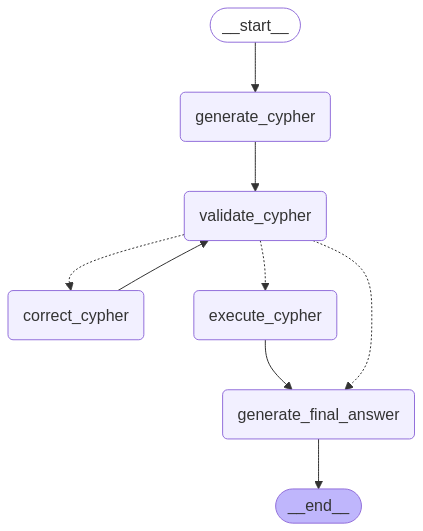

In [43]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph

langgraph = StateGraph(OverallState, input=InputState, output=OutputState)
# langgraph.add_node(guardrails)
langgraph.add_node(generate_cypher)
langgraph.add_node(validate_cypher)
langgraph.add_node(correct_cypher)
langgraph.add_node(execute_cypher)
langgraph.add_node(generate_final_answer)

langgraph.add_edge(START, "generate_cypher")
# langgraph.add_conditional_edges("guardrails",guardrails_condition)
langgraph.add_edge("generate_cypher", "validate_cypher")
langgraph.add_conditional_edges("validate_cypher",validate_cypher_condition)
langgraph.add_edge("execute_cypher", "generate_final_answer")
langgraph.add_edge("correct_cypher", "validate_cypher")
langgraph.add_edge("generate_final_answer", END)

langgraph = langgraph.compile()

# View
display(Image(langgraph.get_graph().draw_mermaid_png()))

In [44]:
results = langgraph.invoke({"question": "How is the Utils.Utils module related to the Deduplicatioin.__Main__ module?"})

MATCH path = (m1:Module {id: 'Utils.Utils'})-[*..5]-(m2:Module {id: 'Deduplication.__Main__'}) 
WHERE NONE(n IN nodes(path) WHERE n:Package) 
RETURN path
[{'path': [{'id': 'Utils.Utils'}, 'USES', {'id': 'Deduplication.Lsh.Lsh.Compute_Minhash_Signatures'}, 'CONTAINS', {'id': 'Deduplication.Lsh.Lsh'}, 'CALLS', {'id': 'Deduplication.__Main__.Model'}, 'INITIALIZES', {'id': 'Deduplication.__Main__.__Main__'}, 'DEFINES', {'id': 'Deduplication.__Main__'}]}, {'path': [{'id': 'Utils.Utils'}, 'USES', {'id': 'Deduplication.Lsh.Lsh.Compute_Minhash_Signatures'}, 'CONTAINS', {'id': 'Deduplication.Lsh.Lsh'}, 'CALLS', {'id': 'Deduplication.__Main__.Model'}, 'DEFINES', {'id': 'Deduplication.__Main__'}]}, {'path': [{'id': 'Utils.Utils'}, 'USES', {'id': 'Deduplication.Lsh.Lsh.Compute_Minhash_Signatures'}, 'CONTAINS', {'id': 'Deduplication.Lsh.Lsh'}, 'CALLS', {'id': 'Deduplication.__Main__.Model'}, 'USES', {'id': 'Deduplication.Lshimproved.Lsh'}, 'IMPORTS', {'id': 'Deduplication.__Main__'}]}, {'path': [{'

In [45]:
results['cypher_results']

[{'path': [{'id': 'Utils.Utils'},
   'USES',
   {'id': 'Deduplication.Lsh.Lsh.Compute_Minhash_Signatures'},
   'CONTAINS',
   {'id': 'Deduplication.Lsh.Lsh'},
   'CALLS',
   {'id': 'Deduplication.__Main__.Model'},
   'INITIALIZES',
   {'id': 'Deduplication.__Main__.__Main__'},
   'DEFINES',
   {'id': 'Deduplication.__Main__'}]},
 {'path': [{'id': 'Utils.Utils'},
   'USES',
   {'id': 'Deduplication.Lsh.Lsh.Compute_Minhash_Signatures'},
   'CONTAINS',
   {'id': 'Deduplication.Lsh.Lsh'},
   'CALLS',
   {'id': 'Deduplication.__Main__.Model'},
   'DEFINES',
   {'id': 'Deduplication.__Main__'}]},
 {'path': [{'id': 'Utils.Utils'},
   'USES',
   {'id': 'Deduplication.Lsh.Lsh.Compute_Minhash_Signatures'},
   'CONTAINS',
   {'id': 'Deduplication.Lsh.Lsh'},
   'CALLS',
   {'id': 'Deduplication.__Main__.Model'},
   'USES',
   {'id': 'Deduplication.Lshimproved.Lsh'},
   'IMPORTS',
   {'id': 'Deduplication.__Main__'}]},
 {'path': [{'id': 'Utils.Utils'},
   'USES',
   {'id': 'Deduplication.Lsh.Lsh.Co

In [46]:
print(results.get("answer"))

The Utils.Utils module is related to the Deduplication.__Main__ module through several intermediate connections:

1. Utils.Utils uses the Compute_Minhash_Signatures function from Deduplication.Lsh.Lsh.
2. Deduplication.Lsh.Lsh calls or uses the Model class from Deduplication.__Main__.
3. The Deduplication.__Main__ module defines the Model class and the __Main__ class.

Additionally, there are indirect connections through other modules like Lshimproved.Lsh and Lshforest.Lshforest, which are imported by Deduplication.__Main__. 

In summary, Utils.Utils is primarily connected to Deduplication.__Main__ through the use of shared components and dependencies within the Deduplication system, particularly through the Lsh module and the Model class.


# Text Answer with RAG

In [49]:
import getpass
import os
from langchain_openai import OpenAIEmbeddings
from langchain.chat_models import init_chat_model
from langchain_anthropic import ChatAnthropic


llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [50]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [51]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [52]:
# from langchain_neo4j import Neo4jGraph

# import os
# from dotenv import load_dotenv

# # You can pass the path if the file isn't in the same directory
# load_dotenv(dotenv_path='../../.env')

# # Access your variables
# pinecone_api = os.getenv('PINECONE_API_KEY')

In [53]:
# from langchain_pinecone import PineconeVectorStore
# from pinecone import Pinecone

# pc = Pinecone(api_key=pinecone_api)
# index = pc.Index('llama-text-embed-v2-index')
# vector_store = PineconeVectorStore(embedding=embeddings, index=index)

In [54]:
import os

def generate_repo_tree(repo_path, indent=""):
    tree_string = ""
    for root, dirs, files in os.walk(repo_path):
        # Filter out __pycache__ and hidden directories
        dirs[:] = [d for d in dirs if d != "__pycache__" and not d.startswith(".")]
        files = [f for f in files if not f.startswith(".")]

        level = root.replace(repo_path, "").count(os.sep)
        indent = "│   " * level + "├── "  # Formatting the tree
        tree_string += f"{indent}{os.path.basename(root)}/\n"

        sub_indent = "│   " * (level + 1) + "├── "
        for file in files:
            tree_string += f"{sub_indent}{file}\n"

    return tree_string

# Set your repo path
repo_path = "./assignment-2-mcdonald-s/src"  # Change this to your cloned repo path

# Generate tree and store as string
repo_tree_string = generate_repo_tree(repo_path)

# Print the repo tree
print(repo_tree_string)

# Store it as a variable to feed into an LLM
# llm_input = f"Here is the repository structure:\n{repo_tree_string}"


├── src/
│   ├── deduplication/
│   │   ├── bloom_filter.py
│   │   ├── dedup.py
│   │   ├── LSH.py
│   │   ├── LSHForest.py
│   │   ├── LSHImproved.py
│   │   ├── __init__.py
│   │   ├── __main__.py
│   ├── utils/
│   │   ├── use_cases.py
│   │   ├── utils.py
│   │   ├── visualizations.py
│   │   ├── visualization_lsh.py



In [ ]:

from langchain.chat_models import init_chat_model
from typing_extensions import Annotated, TypedDict
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer


llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")

system_prompt = """
    You are an expert in translating code into natural language.
    Your goal is to generate a natural language description of the code in the given file.
    The description should be in a natural language format, and in great detail, but it should not be too verbose.
    """



import os

i = 0
descriptions = {}

for root, dirs, files in os.walk(repo_path):
    
    # Skip hidden directories (e.g., .git, .idea, __pycache__)
    dirs[:] = [d for d in dirs if not d.startswith(".") and d != "__pycache__"]

    for file in files:
        if file.startswith("."):
            continue  # Skip hidden files

        file_path = os.path.join(root, file)
        relative_path = os.path.relpath(file_path, repo_path)
        rel_path = relative_path.replace("\\", ".")
        print(rel_path)

        try:
            with open(file_path, "r", encoding="utf-8") as f:
                lsh_code = f.read()

            messages = [
                SystemMessage(system_prompt),
                HumanMessage(f'''
                    Tree:
                    {repo_tree_string}

                    Current File Path:
                    {rel_path}

                    Code:
                    {lsh_code}
                ''')
            ]

            response = llm.invoke(messages)
            descriptions[rel_path] = response.content
            i += 1

        except Exception as e:
            print(f"Error processing {file_path}: {e}")



deduplication.bloom_filter.py
deduplication.dedup.py
deduplication.LSH.py
deduplication.LSHForest.py
deduplication.LSHImproved.py
deduplication.__init__.py
deduplication.__main__.py
utils.use_cases.py
utils.utils.py
utils.visualizations.py
utils.visualization_lsh.py


In [56]:
descriptions = {k.replace('\\', '.'): v for k, v in descriptions.items()}


In [57]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)


all_docs = []
for i in descriptions:
    docs = text_splitter.create_documents([descriptions[i]])
    for d in docs:
        d.metadata['source'] = i
    all_docs.extend(docs)

In [ ]:
_ - vector_store.add_documents(documents=all_docs)

['184d7df5-6d05-4210-ac5f-67e6cb44adb8',
 '89204364-381a-428a-b0f4-1df5b60c6b54',
 'ada3274e-56a7-4a82-93a9-f48ade131bf6',
 'eda80cd4-3ed4-4bd1-a1cf-7c778614bf52',
 '9c913c54-8f6d-419a-9c87-d23534498169',
 'af9c56e3-1f06-464d-bc53-e96822a5981f',
 'b8ea34b2-0a72-4928-a277-e4dba4f200eb',
 'dbf201b2-1ea4-41a9-87b3-191569b37b3f',
 '5cb92725-f21c-467d-b649-4ef1d02128fe',
 '784bfa80-e615-4ebc-bf3a-e79bb95a172f',
 '8dbf4008-dd62-491c-9614-44ed8cb38367',
 'c8677b4e-6bb6-423b-bd75-ed2b1be87f8c',
 '6b9f04eb-4bdc-45db-803c-91e55872c2d8',
 '7958c971-0705-4858-8a76-7972c1353590',
 'fd70693c-ad54-472a-bb60-334bf36791f6',
 '4dd23362-ff22-4fe2-b5fc-11ef31c5dffb',
 'd2915f97-a32d-40cf-a484-2e6943129c16',
 'bf5ea85a-6957-412d-84ac-f41bb6e6b053',
 'e8328835-7ef0-4859-b7da-6cf1d9f94088',
 'f93397ea-0056-4140-90c7-55a2af0b900e',
 '88fe1e2b-4728-48fa-b14b-fcfad8de7fe1',
 'f093b9bd-e97d-4c37-80d8-b84754913ed9',
 '24c19ec0-bf60-41db-b6c4-8c65abfe6a7b',
 'fb3b64c6-7713-4894-bae7-67055dcb94d5',
 '5d894556-cc9d-

In [90]:
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict


from langchain_core.prompts import ChatPromptTemplate

system_prompt = """
You are an expert in adding relevant details to a GRAPH RAG queried statement. You will be given a sentence to analyze (which is the output of a cypher query) and a context (which is additional information on the nodes and relationships). 
Your task is to add relevant details to the sentence to make it more informative and useful. The context will be used to provide additional information about the entities and relationships in the sentence.
Sentence to analyze: {question}
Context: {context}
Answer:
"""

prompt = ChatPromptTemplate.from_template(system_prompt)

# Define prompt for question-answering
# prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"], k=10)
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [91]:
result = graph.invoke({"question": results.get("answer")})

In [92]:
print(result['answer'])

The Utils.Utils module is intricately related to the Deduplication.__Main__ module through several intermediate connections, reflecting a well-structured framework that enhances document deduplication capabilities. Here are the key points of this relationship:

1. **Function Utilization**: The Utils.Utils module utilizes the `Compute_Minhash_Signatures` function from Deduplication.Lsh.Lsh, which plays a crucial role in generating MinHash signatures for documents. This computational function is essential for the efficiency of the deduplication process, as it allows for quick similarity comparisons between documents based on their hashed representations.

2. **Class Interdependency**: The Deduplication.Lsh.Lsh module invokes the `Model` class from Deduplication.__Main__. This class serves as the backbone of the deduplication system, encapsulating core functionalities and configurations necessary for implementing various LSH-based methods effectively. The relationship emphasizes a modular

In [ ]:
import os
from rag_graph import create_rag_graph, RAGGraph

def main():
    # Set your repo path
    repo_path = "./assignment-2-mcdonald-s/src"  # Change this to your cloned repo path
    
    # You can provide API keys here or they will be requested via getpass
    # openai_api_key = "your-openai-api-key"
    # anthropic_api_key = "your-anthropic-api-key"
    
    # Create the RAG graph
    rag = create_rag_graph(
        repo_path=repo_path,
        # openai_api_key=openai_api_key,  # Uncomment to provide key directly
        # anthropic_api_key=anthropic_api_key,  # Uncomment to provide key directly
        embedding_model="text-embedding-3-large",
        llm_model="claude-3-5-sonnet-20240620",
    )
    
    # Alternative: Initialize step by step if you want more control
    # rag = RAGGraph(repo_path=repo_path)
    # rag.generate_repo_tree()
    # rag.generate_code_descriptions()
    # rag.build_vector_store()
    # rag.build_graph()
    
    # Query the graph
    question = "How does the McDonald's application handle orders?"
    answer = rag.query(question)
    
    print(f"Question: {question}")
    print(f"Answer: {answer}")

In [98]:
from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt
import json
from typing import List, Dict, Any

def visualize_cypher_results(cypher_results: List[Dict[str, Any]], output_file: str = "cypher_graph.html"):
    """
    Visualize Cypher query results using Pyvis.
    
    Args:
        cypher_results: List of path results from Cypher query
        output_file: Output HTML file name
    """
    # Create Pyvis network
    net = Network(notebook=False, cdn_resources='in_line', height="800px", width="100%")
    
    # Create a NetworkX graph
    G = nx.DiGraph()  # Using DiGraph for directed relationships
    
    # Track unique nodes and edges to avoid duplicates
    unique_nodes = set()
    unique_edges = set()
    
    # Extract node metadata (type from ID prefix)
    node_metadata = {}
    
    # Process each path in the results
    for result in cypher_results:
        path = result.get('path', [])
        
        # Paths alternate between nodes and relationships
        for i in range(0, len(path), 2):
            # Add node
            if i < len(path):
                node = path[i]
                node_id = node.get('id')
                if node_id and node_id not in unique_nodes:
                    unique_nodes.add(node_id)
                    # Extract node type from ID (assuming format like "Type.Name")
                    node_parts = node_id.split('.')
                    node_type = node_parts[0] if len(node_parts) > 0 else "Unknown"
                    
                    # Store node metadata
                    node_metadata[node_id] = {
                        "id": node_id,
                        "type": node_type,
                        "properties": {}
                    }
                    
                    # Add node to NetworkX graph
                    G.add_node(node_id)
            
            # Add relationship/edge
            if i + 1 < len(path) and i + 2 < len(path):
                source_id = path[i].get('id')
                relationship = path[i + 1]  # This is a string like "USES"
                target_id = path[i + 2].get('id')
                
                if source_id and target_id:
                    edge_key = (source_id, target_id, relationship)
                    if edge_key not in unique_edges:
                        unique_edges.add(edge_key)
                        # Add edge to NetworkX graph
                        G.add_edge(source_id, target_id, label=relationship)
    
    # Get unique types for coloring
    unique_types = list(set(meta["type"] for meta in node_metadata.values()))
    color_map = plt.get_cmap("tab10")
    type_colors = {t: color_map(i / len(unique_types)) for i, t in enumerate(unique_types)}
    type_colors_rgba = {
        t: f'rgba({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)}, 0.8)' 
        for t, c in type_colors.items()
    }
    
    # Degree-based sizing
    degrees = dict(G.degree())
    min_size, max_size = 15, 50
    max_degree = max(degrees.values()) if degrees else 1
    size_scale = {
        node: min_size + (max_size - min_size) * (deg / max_degree)
        for node, deg in degrees.items()
    }
    
    # Add nodes to Pyvis with proper styling
    for node_id in G.nodes():
        metadata = node_metadata.get(node_id, {})
        label = node_id.split('.')[-1]  # Use last part of ID as label for cleaner display
        node_type = metadata.get("type", "Unknown")
        color = type_colors_rgba.get(node_type, "gray")
        
        # Add node to Pyvis network
        net.add_node(
            node_id,
            label=label,
            size=size_scale[node_id],
            color=color,
            title=f"<b>{node_type}</b><br>{node_id}"
        )
    
    # Add edges to Pyvis
    for source, target, attr in G.edges(data=True):
        rel_label = attr.get("label", "")
        net.add_edge(source, target, title=rel_label, label=rel_label, arrows='to')
    
   
    # Save graph
    net.save_graph(output_file)
    
    # Build legend
    legend_html = """
    <div id="legend" style="position: absolute; top: 10px; left: 10px; background: white; padding: 10px; border-radius: 8px; box-shadow: 0px 0px 5px rgba(0,0,0,0.2); font-family: Arial, sans-serif; z-index: 1000;">
        <h4 style="margin: 0; padding-bottom: 5px;">Node Legend</h4>
    """
    
    for node_type, color in type_colors_rgba.items():
        legend_html += f'<div style="display: flex; align-items: center; margin-bottom: 5px;"><div style="width: 15px; height: 15px; background:{color}; margin-right: 5px; border-radius: 50%;"></div> {node_type}</div>'
    
    legend_html += """
        <h4 style="margin: 5px 0; padding-bottom: 5px;">Relationship Legend</h4>
    """
    
    for rel_type in sorted(set(attr.get("label", "") for _, _, attr in G.edges(data=True))):
        legend_html += f'<div style="display: flex; align-items: center; margin-bottom: 5px;"><div style="width: 20px; height: 2px; background: #666; margin-right: 5px;"></div> {rel_type}</div>'
    
    legend_html += "</div>"
    
    # Inject legend into the HTML
    with open(output_file, "r", encoding="utf-8") as file:
        html_content = file.read()
    
    html_content = html_content.replace("</body>", legend_html + "</body>")
    
    with open(output_file, "w", encoding="utf-8") as file:
        file.write(html_content)
    
    print(f"Graph visualization saved as {output_file}")
    
    # Return graph stats
    return {
        "nodes": len(G.nodes()),
        "edges": len(G.edges()),
        "node_types": unique_types,
        "relationship_types": list(set(attr.get("label", "") for _, _, attr in G.edges(data=True)))
    }

In [99]:
stats = visualize_cypher_results(results['cypher_results'], "code_relationships_graph.html")


Graph visualization saved as code_relationships_graph.html


In [106]:
"""
Visualize a graph from Cypher query results using Pyvis and NetworkX.
"""
from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt
import json
from typing import List, Dict, Any

def visualize_cypher_results(cypher_results: List[Dict[str, Any]], output_file: str = "cypher_graph.html"):
    """
    Visualize Cypher query results using Pyvis.
    
    Args:
        cypher_results: List of path results from Cypher query
        output_file: Output HTML file name
    """
    # Create Pyvis network
    net = Network(notebook=False, cdn_resources='in_line', height="800px", width="100%")
    
    # Create a NetworkX graph
    G = nx.DiGraph()  # Using DiGraph for directed relationships
    
    # Track unique nodes and edges to avoid duplicates
    unique_nodes = set()
    unique_edges = set()
    
    # Extract node metadata (type from ID prefix)
    node_metadata = {}
    
    # Process each path in the results
    for result in cypher_results:
        path = result.get('path', [])
        
        # Paths alternate between nodes and relationships
        for i in range(0, len(path), 2):
            # Add node
            if i < len(path):
                node = path[i]
                node_id = node.get('id')
                if node_id and node_id not in unique_nodes:
                    unique_nodes.add(node_id)
                    # Extract node type from ID (assuming format like "Type.Name")
                    node_parts = node_id.split('.')
                    node_type = node_parts[0] if len(node_parts) > 0 else "Unknown"
                    
                    # Store node metadata
                    node_metadata[node_id] = {
                        "id": node_id,
                        "type": node_type,
                        "properties": {}
                    }
                    
                    # Add node to NetworkX graph
                    G.add_node(node_id)
            
            # Add relationship/edge
            if i + 1 < len(path) and i + 2 < len(path):
                source_id = path[i].get('id')
                relationship = path[i + 1]  # This is a string like "USES"
                target_id = path[i + 2].get('id')
                
                if source_id and target_id:
                    edge_key = (source_id, target_id, relationship)
                    if edge_key not in unique_edges:
                        unique_edges.add(edge_key)
                        # Add edge to NetworkX graph
                        G.add_edge(source_id, target_id, label=relationship)
    
    # Get unique types for coloring
    unique_types = list(set(meta["type"] for meta in node_metadata.values()))
    color_map = plt.get_cmap("tab10")
    type_colors = {t: color_map(i / len(unique_types)) for i, t in enumerate(unique_types)}
    type_colors_rgba = {
        t: f'rgba({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)}, 0.8)' 
        for t, c in type_colors.items()
    }
    
    # Degree-based sizing
    degrees = dict(G.degree())
    min_size, max_size = 15, 50
    max_degree = max(degrees.values()) if degrees else 1
    size_scale = {
        node: min_size + (max_size - min_size) * (deg / max_degree)
        for node, deg in degrees.items()
    }
    
    # Add nodes to Pyvis with proper styling
    for node_id in G.nodes():
        metadata = node_metadata.get(node_id, {})
        node_type = metadata.get("type", "Unknown")
        color = type_colors_rgba.get(node_type, "gray")
        
        # Show full node ID as the label
        # Add node to Pyvis network
        net.add_node(
            node_id,
            label=node_id,  # Using full node_id as the label
            size=size_scale[node_id],
            color=color,
            title=f"<b>{node_type}</b><br>{node_id}"
        )
    
    # Get all unique relationship types
    relationship_types = list(set(attr.get("label", "") for _, _, attr in G.edges(data=True)))
    
    # Create colors for each relationship type
    rel_color_map = plt.get_cmap("Set2")  # Using a different colormap for relationships
    rel_colors = {
        rel_type: f'rgba({int(rel_color_map(i / len(relationship_types))[0]*255)}, {int(rel_color_map(i / len(relationship_types))[1]*255)}, {int(rel_color_map(i / len(relationship_types))[2]*255)}, 0.9)'
        for i, rel_type in enumerate(relationship_types)
    }
    
    # Add edges to Pyvis with longer length and different colors
    for source, target, attr in G.edges(data=True):
        rel_label = attr.get("label", "")
        edge_color = rel_colors.get(rel_label, "#888888")  # Default gray if not found
        # Adding longer length to edges (300 instead of default)
        net.add_edge(source, target, title=rel_label, label=rel_label, arrows='to', length=300, color=edge_color)
    
    # Save graph
    net.save_graph(output_file)
    
    # Build legend
    legend_html = """
    <div id="legend" style="position: absolute; top: 10px; left: 10px; background: white; padding: 10px; border-radius: 8px; box-shadow: 0px 0px 5px rgba(0,0,0,0.2); font-family: Arial, sans-serif; z-index: 1000;">
        <h4 style="margin: 0; padding-bottom: 5px;">Node Legend</h4>
    """
    
    for node_type, color in type_colors_rgba.items():
        legend_html += f'<div style="display: flex; align-items: center; margin-bottom: 5px;"><div style="width: 15px; height: 15px; background:{color}; margin-right: 5px; border-radius: 50%;"></div> {node_type}</div>'
    
    legend_html += """
        <h4 style="margin: 5px 0; padding-bottom: 5px;">Relationship Legend</h4>
    """
    
    for rel_type in sorted(relationship_types):
        rel_color = rel_colors.get(rel_type, "#888888")
        legend_html += f'<div style="display: flex; align-items: center; margin-bottom: 5px;"><div style="width: 20px; height: 3px; background: {rel_color}; margin-right: 5px;"></div> {rel_type}</div>'
    
    legend_html += "</div>"
    
    # Inject legend into the HTML
    with open(output_file, "r", encoding="utf-8") as file:
        html_content = file.read()
    
    html_content = html_content.replace("</body>", legend_html + "</body>")
    
    with open(output_file, "w", encoding="utf-8") as file:
        file.write(html_content)
    
    print(f"Graph visualization saved as {output_file}")
    
    # Return graph stats
    return {
        "nodes": len(G.nodes()),
        "edges": len(G.edges()),
        "node_types": unique_types,
        "relationship_types": list(set(attr.get("label", "") for _, _, attr in G.edges(data=True)))
    }

In [107]:
stats = visualize_cypher_results(results['cypher_results'], "code_relationships_graph.html")


Graph visualization saved as code_relationships_graph.html


In [108]:
stats

{'nodes': 8,
 'edges': 12,
 'node_types': ['Utils', 'Deduplication'],
 'relationship_types': ['CONTAINS',
  'USES',
  'DEFINES',
  'IMPORTS',
  'INHERITS',
  'INITIALIZES']}